## LB Drives - Machine Learning Analysis (work in progress)

### Background
![drive](img/drive.jpg)
The mill is developing an initiative to monitor the state of drives being used in the paper making process via mathematically analysing the stream of key process variables. Depending on the condition of the drive, given by some key variables associated with each individual equipment, the system triggers a maintenance notification. While the notification is open, the variable status gets a value that shows it is under maintenance. When the notification is closed, the variable status gets back to normal. 


### Data available

Two excel files were generated with information related to several drives during the period of one month with one observation per minute. The input file shows a bigger subset of the drives available in the mill. The output file include 10 drivers under the monitoring initiative with its condition state (normal or under maintenance).

### The approach

We split the output and input data into separate files and then combine the variables that indicate the condition of the equipment. While we combine the variables together, we check for data that is invalid (eg text in numerical values), missing values etc. This is an important step to guarantee the model will work as expected. 

Next, we apply a machine learning technique to try to create a model for each drive that could reflect the combined state of the variables impacting the equipment condition. During this process, we will also try to predict the condition of the equipment using a generic model (based on one the equipment only). 

### How to interpret the results

We will generate the models using a classification method called random decision trees (random forest/extra trees). After the model is created, we use it to predict the variable status based on out of the sample data (variables about the condition of the equipment). 

We are randonly splitting the data, with observations from 30 days, into training and test data with a proportion of 70/30. The metrics are calculated comparing the real data with the prediction data so that we can estimate how reliable the model is. For that, we can use the metrics accuracy, precision and recall. In general, rates close to 1 indicate an excellent prediction result. The Confusion Matrix shows the overall picture of those metrics, indicating what was measured right and wrong (true positives, true negatives, false positives and false negatives). 

Finally, we list the most important variables that collaborated to create the model. This provides an insight on what information is relevant for the prediction step. 


### The main code and the results

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  7 09:01:16 2016
@author: DEDUS-RobertoMa
"""
%matplotlib inline
#initialization of libraries
from __future__ import print_function
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import glob
import itertools
#scikit learn functions
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# Configure here for your local machine
base_data_path = "/Users/rerngvit/Dropbox/coding_workspace/analytic-workspace/combient/poc_stora_lb_drives/data/individual_drives/"
preparation_path = "/Users/rerngvit/Dropbox/coding_workspace/analytic-workspace/combient/poc_stora_lb_drives/data/preparation/"
model_data_path = "/Users/rerngvit/Dropbox/coding_workspace/analytic-workspace/combient/poc_stora_lb_drives/data/building_model/"

In [16]:
#%% function to print and plot the confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [138]:
import time
def get_numeric_features(raw_pd, drive_name):
    features = [col_name for col_name in raw_pd.columns if drive_name in col_name
                   and "_status" not in col_name
                   and "_Run_Feedback" not in col_name]
    return features


def add_rolling_metrics(raw_pd, field_id_list=["value"], window_size_list=[5]):
    prepared_pd = pd.DataFrame()
    for field_id in field_id_list:
        for window_size in window_size_list:
            start_time = time.time()
            field_name = "%s_EXPANDED_AVG_W%s" % (field_id, window_size)  
            prepared_pd[field_name] = raw_pd.rolling(window=window_size).mean()[field_id]
            field_name = "%s_EXPANDED_STD_W%s" % (field_id, window_size) 
            prepared_pd[field_name] = raw_pd.rolling(window=window_size).std()[field_id]
            field_name = "%s_EXPANDED_MIN_W%s" % (field_id, window_size) 
            prepared_pd[field_name] = raw_pd.rolling(window=window_size).min()[field_id]  
            
            field_name = "%s_EXPANDED_MAX_W%s" % (field_id, window_size) 
            prepared_pd[field_name] = raw_pd.rolling(window=window_size).max()[field_id]  
            
            field_name = "%s_EXPANDED_SKEWNESS_W%s" % (field_id, window_size) 
            prepared_pd[field_name] = raw_pd.rolling(window=window_size).skew()[field_id]  

    
    raw_pd      = raw_pd.iloc[(max(window_size_list)):, :]
    prepared_pd = prepared_pd.iloc[(max(window_size_list)):, :]
    prepared_pd = prepared_pd.dropna()

#    print(prepared_pd.shape)
#    print(raw_pd.shape)
    prepared_pd.index = raw_pd.index
    
    return pd.concat([raw_pd, prepared_pd], axis=1)

def add_diff_previous(raw_pd, field_id_list=["value"], shift_period_list=[1]):
    prepared_pd = pd.DataFrame()
    for field_id in field_id_list:
        for shift_period in shift_period_list:
            start_time = time.time()
            field_name = "%s_EXPANDED_SHIFT_P%s" % (field_id, shift_period)
            prepared_pd[field_name] = raw_pd[str(field_id)] - raw_pd[str(field_id)].shift(periods=shift_period)    
#             print(" Adding diff previous for feature %s window size = %s takes %.2f " % 
#                   (field_id,
#                    shift_period,
#                    time.time() - start_time))
    
    raw_pd      = raw_pd.iloc[max(shift_period_list):, :]
    prepared_pd = prepared_pd.iloc[max(shift_period_list):, :]
    prepared_pd.index = raw_pd.index
    return pd.concat([raw_pd, prepared_pd], axis=1)

def get_feature_engineered_pd(raw_pd, drive_name):
    print(" Engineering features for drive %s " % drive_name)
    prepared_pd = raw_pd.copy()
    features = get_numeric_features(prepared_pd, drive_name)
    
    prepared_pd = add_diff_previous(prepared_pd, field_id_list=features, shift_period_list=[1, 2, 4, 8, 16])
    prepared_pd = add_rolling_metrics(prepared_pd, field_id_list=features, window_size_list=[5, 10, 20, 40, 80])
    print(" Engineering features for drive %s Done! " % drive_name)
    return prepared_pd



In [139]:
add_diff_previous(pd.DataFrame({"value": np.arange(10)}), field_id_list=["value"])

value  value_EXPANDED_SHIFT_P1
1      1                      1.0
2      2                      1.0
3      3                      1.0
4      4                      1.0
5      5                      1.0
6      6                      1.0
7      7                      1.0
8      8                      1.0
9      9                      1.0

In [116]:
get_numeric_features(prepared_sample, "LM-41BAL300")

['LM-41BAL300.drv_Frequentie',
 'LM-41BAL300.drv_Koppel',
 'LM-41BAL300.drv_Snelheid',
 'LM-41BAL300.drv_Stroom',
 'LM-41BAL300.drv_Temperatuur',
 'LM-41BAL300.drv_Temperatuur_ER']

In [58]:
prepared_sample = pd.read_excel(preparation_path + "LM-41BAL300.drv_df_train.xlsx")
prepared_sample

LM-41BAL300.drv_Frequentie LM-41BAL300.drv_Koppel  \
2016-09-01 00:00:00                      33.68                     68   
2016-09-01 00:01:00                      33.52                     65   
2016-09-01 00:02:00                      33.47                67.7143   
2016-09-01 00:03:00                    33.5675                68.9524   
2016-09-01 00:04:00                      33.48                68.3333   
2016-09-01 00:05:00                    33.4683                     66   
2016-09-01 00:06:00                      33.51                 67.875   
2016-09-01 00:07:00                      34.07                     71   
2016-09-01 00:08:00                     34.115                70.7059   
2016-09-01 00:09:00                     34.185                  70.05   
2016-09-01 00:10:00                      34.13                69.9375   
2016-09-01 00:11:00                     34.166                69.8333   
2016-09-01 00:12:00                    34.1133                68.6296   
2016-09-01 00:13:00                    33.5067                66.8333   
2016-09-01 00:14:00                    33.8333                     69   
2016-09-01 00:15:00                     33.505                69.8125   
2016-09-01 00:16:00                    33.8525                   69.4   
2016-09-01 00:17:00                    33.8986                71.6667   
2016-09-01 00:18:00                      33.86                69.6667   
2016-09-01 00:19:00                    33.8267                   70.4   
2016-09-01 00:20:00                      33.84                  68.75   
2016-09-01 00:21:00                    33.4975                65.7273   
2016-09-01 00:22:00                     33.875                     69   
2016-09-01 00:23:00                    33.9055                   68.5   
2016-09-01 00:24:00                      33.71                     69   
2016-09-01 00:25:00                      33.78                   67.6   
2016-09-01 00:26:00                      33.64                67.6667   
2016-09-01 00:27:00                    33.4171                68.8235   
2016-09-01 00:28:00                    33.8425                     70   
2016-09-01 00:29:00                     33.935                69.8667   
...                                        ...                    ...   
2016-10-12 23:31:00                    33.7033                69.9286   
2016-10-12 23:32:00                      33.67                68.6538   
2016-10-12 23:33:00                    33.7969                   69.6   
2016-10-12 23:34:00                    33.7088                 68.775   
2016-10-12 23:35:00                       33.7                     70   
2016-10-12 23:36:00                    33.9933                   70.5   
2016-10-12 23:37:00                    34.5067                   72.5   
2016-10-12 23:38:00                    34.7367                     72   
2016-10-12 23:39:00                     34.445                70.7083   
2016-10-12 23:40:00                    34.1586                     71   
2016-10-12 23:41:00                      34.31                     72   
2016-10-12 23:42:00                    34.3333                71.4118   
2016-10-12 23:43:00                      33.86                     69   
2016-10-12 23:44:00                      33.95                     70   
2016-10-12 23:45:00                      33.79                     69   
2016-10-12 23:46:00                      33.73                     69   
2016-10-12 23:47:00                    34.1717                69.7647   
2016-10-12 23:48:00                      33.94                68.1429   
2016-10-12 23:49:00                      34.15                71.5417   
2016-10-12 23:50:00                      34.14                69.4857   
2016-10-12 23:51:00                      33.86                68.2667   
2016-10-12 23:52:00                    34.2233                70.3125   
2016-10-12 23:53:00                       33.8                71.8889   
2016-

In [136]:
engineered_pd = get_pred_pd(prepared_sample, "LM-41BAL300.drv")

In [96]:
[col for col in engineered_pd.columns if "status" in col]

['LM-41BAL300.drv_status']

In [135]:
#%% preprocessing 
def process_drive_file(drive_name, seq):  
    print(" processing drive %s " % drive_name)
    df_in = pd.read_excel(base_data_path + "input_"+ drive_name+".xlsx")
    df_in.index = df_in.index.strftime("%Y-%m-%d %H:%M:%S")
    df_out = pd.read_excel(base_data_path +  "output_"+drive_name+".xlsx")
    df_out.index = df_out.index.strftime("%Y-%m-%d %H:%M:%S")
    df = pd.concat([df_in, df_out], axis=1)
    
    var_status = drive_name + '_status'
    print("\n",seq,"- Drive:", drive_name)
    df_train = df
    df_train.to_excel(preparation_path + drive_name +"_df_train.xlsx")
    var_remove1 = drive_name + "_Temperatuur_ER"
    var_remove2 = drive_name + "_Run_Feedback"
    #print("Before row conditions remove:",df_train.shape)    
    df_train = df_train.drop([var_remove1], axis=1)
    df_train = df_train.drop([var_remove2], axis=1)
    df_train = df_train[df_train[drive_name+"_Koppel"] != 'Intf Shut']
    df_train = df_train[df_train[drive_name+"_Frequentie"] != 'Intf Shut']
    df_train = df_train[df_train[drive_name+"_Frequentie"] != 'I/O Timeout']
    df_train = df_train[df_train[drive_name+"_Koppel"] != 'Scan Timeout']
    #print("after forth row condition remove:",df_train.shape)

    try: 
        df_train[var_status] = df_train[var_status].astype('category')
    except Exception:
        var_status = var_status.replace(".drv","")
    df_train[var_status] = df_train[var_status].replace(1,"maintenance")
    df_train[var_status] = df_train[var_status].replace(0,"normal")
    #print("before dropna:",df_train.shape)        
    df_train = df_train.dropna()
    #print("after dropna:",df_train.shape)       


    df_train_engineered = get_feature_engineered_pd(df_train, drive_name)
    df_train_engineered.to_excel(preparation_path + drive_name +"_df_train_engineered.xlsx")
        

        

In [122]:
def prepare_build_model_data(drive_name):
    df_train = pd.read_excel( preparation_path + drive_name + "_df_train_engineered.xlsx")
    var_status = drive_name + '_status'
    columns = df_train.drop([var_status], axis=1).columns
    target = df_train.ix[:,[var_status]].columns
    train = df_train.sample(frac = 0.70)
    test = df_train.loc[~df_train.index.isin(train.index)]
    return train, test, columns, target, drive_name
    
    
    

In [123]:
# model classifier
def rf_class_drive(train, test, columns, target, name):
    #model = RandomForestClassifier(n_estimators = 100, random_state=10)
    model = ExtraTreesClassifier(n_estimators = 100, random_state=10)
    fit = model.fit(train[columns], train[target].values.ravel())
    
    print(" ====== Scores on the train set ==================")
    predictions = model.predict(train[columns])
    accu = accuracy_score(predictions, train[target].values.ravel())
    conf = confusion_matrix(predictions, train[target].values.ravel())
    plot_confusion_matrix(conf,model.classes_)
    print(confusion_matrix(train[target], predictions))
    print(classification_report(train[target], predictions, target_names=model.classes_))
    
    print(" =================================================")
    print(" ====== Scores on the test set ==================")
    predictions = model.predict(test[columns])
    accu = accuracy_score(predictions, test[target].values.ravel())
    conf = confusion_matrix(predictions, test[target].values.ravel())
    plot_confusion_matrix(conf,model.classes_)
    print(confusion_matrix(test[target], predictions))
    print(" =================================================")
    
    
    
    #print("confusion matrix:",conf)
    print("accuracy:",accu)
    #print(precision_recall_fscore_support(predictions, test[target]))
    print(classification_report(test[target], predictions, target_names=model.classes_))
    predictions = pd.DataFrame(predictions)
    val_counts = predictions.apply(pd.value_counts)
    predictions.to_excel(model_data_path + name+"_predictions.xlsx")
    train.to_excel(model_data_path + name+"_train.xlsx")
    test.to_excel(model_data_path + name+"_test.xlsx")
    #print("Value counts:",val_counts)
    importances = fit.feature_importances_[:model.n_features_]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    indices = [i for i in range(0, model.n_features_)]
    # Print the feature ranking
    print("Feature ranking:")
    rge = len(importances)
    for f in indices:
        print("%d. %s (%f)" % (f, columns[f], importances[indices[f]]))
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(rge), importances[indices], yerr=std[indices], color="r", align="center")
    plt.xticks(range(rge), indices) 
    plt.xlim([-1, rge]) 
    plt.show()   
    return model, predictions, accu, conf

 processing drive LM-41BAL380.drv 

 1 of 10 - Drive: LM-41BAL380.drv
 Engineering features for drive LM-41BAL380.drv 
 Engineering features for drive LM-41BAL380.drv Done! 
 ====== Scores on the train set ==================


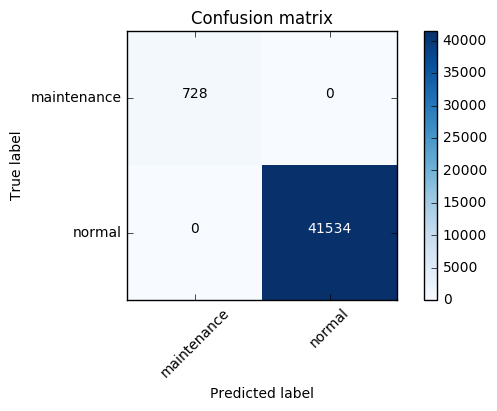

[[  728     0]
 [    0 41534]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       728
     normal       1.00      1.00      1.00     41534

avg / total       1.00      1.00      1.00     42262

 ====== Scores on the test set ==================


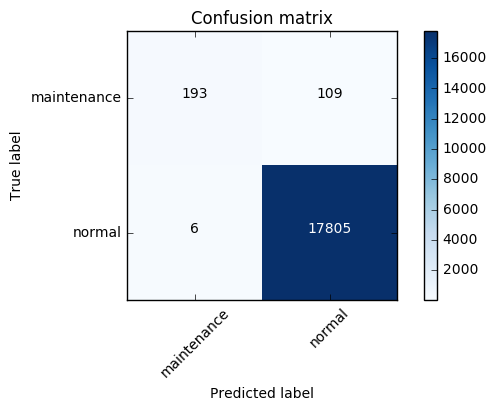

[[  193   109]
 [    6 17805]]
accuracy: 0.993650968917
             precision    recall  f1-score   support

maintenance       0.97      0.64      0.77       302
     normal       0.99      1.00      1.00     17811

avg / total       0.99      0.99      0.99     18113

Feature ranking:
0. LM-41BAL380.drv_Frequentie (0.009012)
1. LM-41BAL380.drv_Koppel (0.004959)
2. LM-41BAL380.drv_Snelheid (0.006603)
3. LM-41BAL380.drv_Stroom (0.005280)
4. LM-41BAL380.drv_Temperatuur (0.007328)
5. LM-41BAL380.drv_Frequentie_EXPANDED_SHIFT_P1 (0.005059)
6. LM-41BAL380.drv_Frequentie_EXPANDED_SHIFT_P2 (0.005674)
7. LM-41BAL380.drv_Frequentie_EXPANDED_SHIFT_P4 (0.005685)
8. LM-41BAL380.drv_Frequentie_EXPANDED_SHIFT_P8 (0.006854)
9. LM-41BAL380.drv_Frequentie_EXPANDED_SHIFT_P16 (0.007898)
10. LM-41BAL380.drv_Koppel_EXPANDED_SHIFT_P1 (0.006098)
11. LM-41BAL380.drv_Koppel_EXPANDED_SHIFT_P2 (0.005788)
12. LM-41BAL380.drv_Koppel_EXPANDED_SHIFT_P4 (0.006709)
13. LM-41BAL380.drv_Koppel_EXPANDED_SHIFT_P8 (0.0076

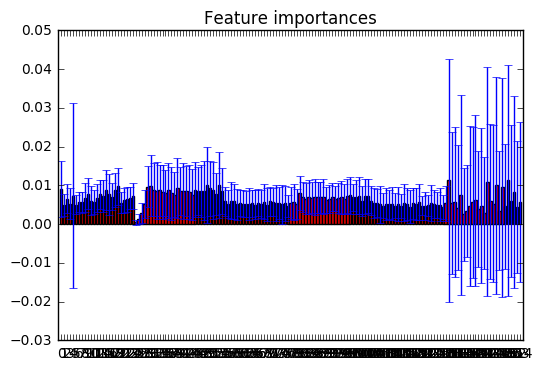

 processing drive LM-41BAL300.drv 

 2 of 10 - Drive: LM-41BAL300.drv
 Engineering features for drive LM-41BAL300.drv 
 Engineering features for drive LM-41BAL300.drv Done! 
 ====== Scores on the train set ==================


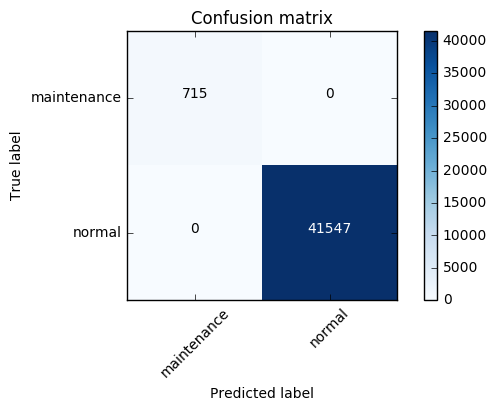

[[  715     0]
 [    0 41547]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       715
     normal       1.00      1.00      1.00     41547

avg / total       1.00      1.00      1.00     42262

 ====== Scores on the test set ==================


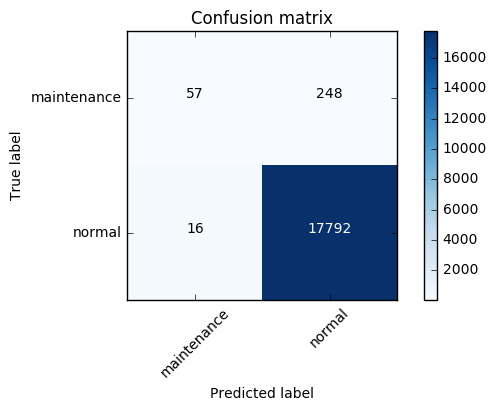

[[   57   248]
 [   16 17792]]
accuracy: 0.985424832993
             precision    recall  f1-score   support

maintenance       0.78      0.19      0.30       305
     normal       0.99      1.00      0.99     17808

avg / total       0.98      0.99      0.98     18113

Feature ranking:
0. LM-41BAL300.drv_Frequentie (0.007021)
1. LM-41BAL300.drv_Koppel (0.005325)
2. LM-41BAL300.drv_Snelheid (0.007663)
3. LM-41BAL300.drv_Stroom (0.005997)
4. LM-41BAL300.drv_Temperatuur (0.004664)
5. LM-41BAL300.drv_Frequentie_EXPANDED_SHIFT_P1 (0.007792)
6. LM-41BAL300.drv_Frequentie_EXPANDED_SHIFT_P2 (0.007916)
7. LM-41BAL300.drv_Frequentie_EXPANDED_SHIFT_P4 (0.009624)
8. LM-41BAL300.drv_Frequentie_EXPANDED_SHIFT_P8 (0.009753)
9. LM-41BAL300.drv_Frequentie_EXPANDED_SHIFT_P16 (0.009334)
10. LM-41BAL300.drv_Koppel_EXPANDED_SHIFT_P1 (0.007702)
11. LM-41BAL300.drv_Koppel_EXPANDED_SHIFT_P2 (0.008046)
12. LM-41BAL300.drv_Koppel_EXPANDED_SHIFT_P4 (0.008237)
13. LM-41BAL300.drv_Koppel_EXPANDED_SHIFT_P8 (0.0087

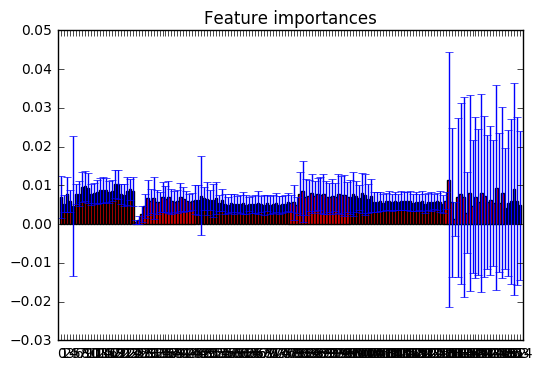

 processing drive LM-41SHL009.2.drv 

 3 of 10 - Drive: LM-41SHL009.2.drv
 Engineering features for drive LM-41SHL009.2.drv 
 Engineering features for drive LM-41SHL009.2.drv Done! 
 ====== Scores on the train set ==================


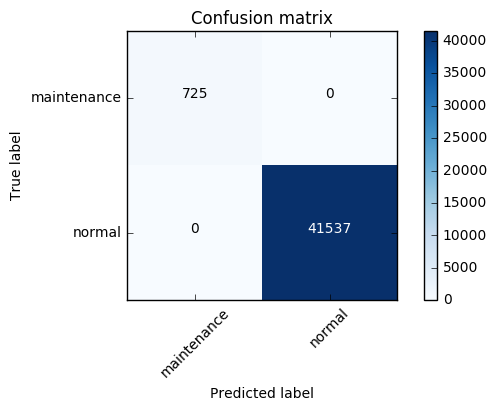

[[  725     0]
 [    0 41537]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       725
     normal       1.00      1.00      1.00     41537

avg / total       1.00      1.00      1.00     42262

 ====== Scores on the test set ==================


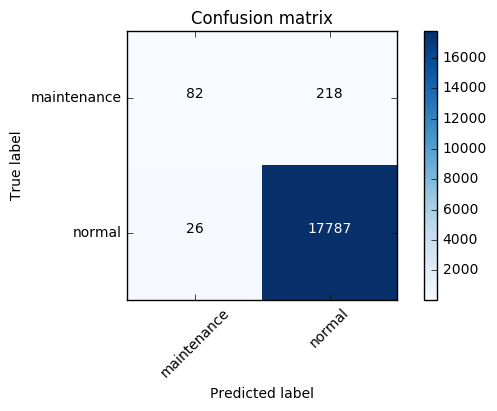

[[   82   218]
 [   26 17787]]
accuracy: 0.986529012312
             precision    recall  f1-score   support

maintenance       0.76      0.27      0.40       300
     normal       0.99      1.00      0.99     17813

avg / total       0.98      0.99      0.98     18113

Feature ranking:
0. LM-41SHL009.2.drv_Frequentie (0.005765)
1. LM-41SHL009.2.drv_Koppel (0.005874)
2. LM-41SHL009.2.drv_Snelheid (0.005689)
3. LM-41SHL009.2.drv_Stroom (0.004878)
4. LM-41SHL009.2.drv_Temperatuur (0.006419)
5. LM-41SHL009.2.drv_Frequentie_EXPANDED_SHIFT_P1 (0.007334)
6. LM-41SHL009.2.drv_Frequentie_EXPANDED_SHIFT_P2 (0.007111)
7. LM-41SHL009.2.drv_Frequentie_EXPANDED_SHIFT_P4 (0.008672)
8. LM-41SHL009.2.drv_Frequentie_EXPANDED_SHIFT_P8 (0.008816)
9. LM-41SHL009.2.drv_Frequentie_EXPANDED_SHIFT_P16 (0.009584)
10. LM-41SHL009.2.drv_Koppel_EXPANDED_SHIFT_P1 (0.008270)
11. LM-41SHL009.2.drv_Koppel_EXPANDED_SHIFT_P2 (0.009551)
12. LM-41SHL009.2.drv_Koppel_EXPANDED_SHIFT_P4 (0.008695)
13. LM-41SHL009.2.drv_Kopp

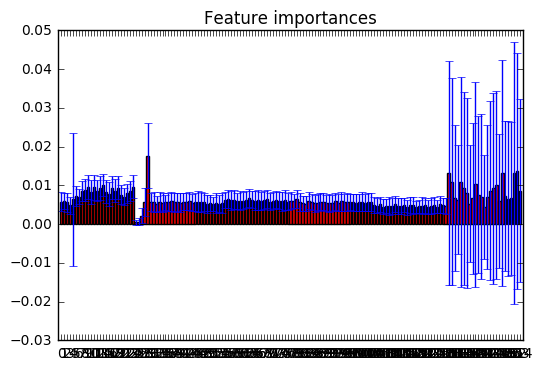

 processing drive LM-41BFL060.1.drv 

 4 of 10 - Drive: LM-41BFL060.1.drv
 Engineering features for drive LM-41BFL060.1.drv 
 Engineering features for drive LM-41BFL060.1.drv Done! 
 ====== Scores on the train set ==================


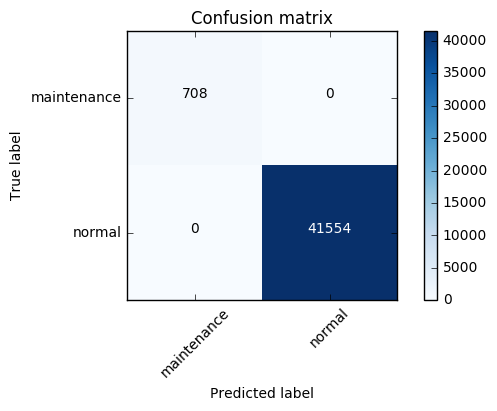

[[  708     0]
 [    0 41554]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       708
     normal       1.00      1.00      1.00     41554

avg / total       1.00      1.00      1.00     42262

 ====== Scores on the test set ==================


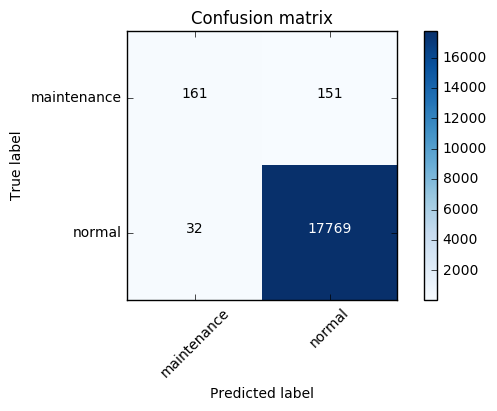

[[  161   151]
 [   32 17769]]
accuracy: 0.989896759234
             precision    recall  f1-score   support

maintenance       0.83      0.52      0.64       312
     normal       0.99      1.00      0.99     17801

avg / total       0.99      0.99      0.99     18113

Feature ranking:
0. LM-41BFL060.1.drv_Frequentie (0.006247)
1. LM-41BFL060.1.drv_Koppel (0.004202)
2. LM-41BFL060.1.drv_Snelheid (0.006301)
3. LM-41BFL060.1.drv_Stroom (0.004828)
4. LM-41BFL060.1.drv_Temperatuur (0.007855)
5. LM-41BFL060.1.drv_Frequentie_EXPANDED_SHIFT_P1 (0.008267)
6. LM-41BFL060.1.drv_Frequentie_EXPANDED_SHIFT_P2 (0.007990)
7. LM-41BFL060.1.drv_Frequentie_EXPANDED_SHIFT_P4 (0.007459)
8. LM-41BFL060.1.drv_Frequentie_EXPANDED_SHIFT_P8 (0.008406)
9. LM-41BFL060.1.drv_Frequentie_EXPANDED_SHIFT_P16 (0.009539)
10. LM-41BFL060.1.drv_Koppel_EXPANDED_SHIFT_P1 (0.006015)
11. LM-41BFL060.1.drv_Koppel_EXPANDED_SHIFT_P2 (0.006669)
12. LM-41BFL060.1.drv_Koppel_EXPANDED_SHIFT_P4 (0.010021)
13. LM-41BFL060.1.drv_Kopp

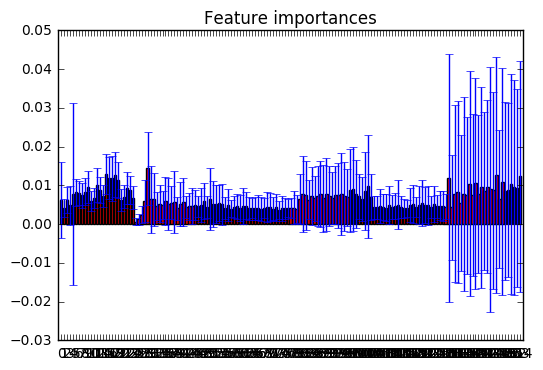

 processing drive LM-41BFL030.1.drv 

 5 of 10 - Drive: LM-41BFL030.1.drv
 Engineering features for drive LM-41BFL030.1.drv 
 Engineering features for drive LM-41BFL030.1.drv Done! 
 ====== Scores on the train set ==================


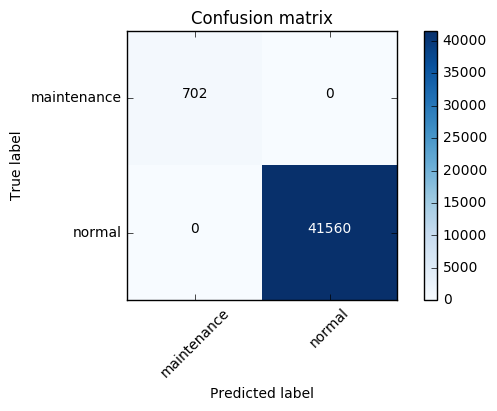

[[  702     0]
 [    0 41560]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       702
     normal       1.00      1.00      1.00     41560

avg / total       1.00      1.00      1.00     42262

 ====== Scores on the test set ==================


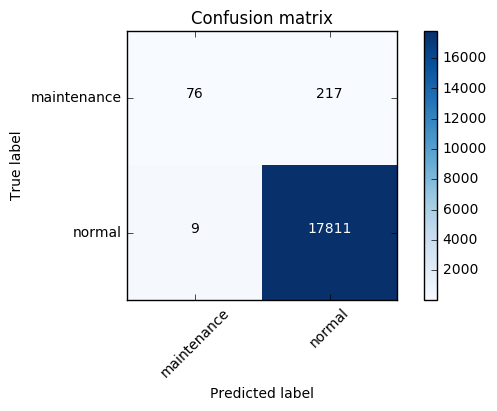

[[   76   217]
 [    9 17811]]
accuracy: 0.987522773698
             precision    recall  f1-score   support

maintenance       0.89      0.26      0.40       293
     normal       0.99      1.00      0.99     17820

avg / total       0.99      0.99      0.98     18113

Feature ranking:
0. LM-41BFL030.1.drv_Frequentie (0.006423)
1. LM-41BFL030.1.drv_Koppel (0.005001)
2. LM-41BFL030.1.drv_Snelheid (0.007234)
3. LM-41BFL030.1.drv_Stroom (0.005177)
4. LM-41BFL030.1.drv_Temperatuur (0.007648)
5. LM-41BFL030.1.drv_Frequentie_EXPANDED_SHIFT_P1 (0.009554)
6. LM-41BFL030.1.drv_Frequentie_EXPANDED_SHIFT_P2 (0.008834)
7. LM-41BFL030.1.drv_Frequentie_EXPANDED_SHIFT_P4 (0.009263)
8. LM-41BFL030.1.drv_Frequentie_EXPANDED_SHIFT_P8 (0.008907)
9. LM-41BFL030.1.drv_Frequentie_EXPANDED_SHIFT_P16 (0.009882)
10. LM-41BFL030.1.drv_Koppel_EXPANDED_SHIFT_P1 (0.008812)
11. LM-41BFL030.1.drv_Koppel_EXPANDED_SHIFT_P2 (0.007719)
12. LM-41BFL030.1.drv_Koppel_EXPANDED_SHIFT_P4 (0.009031)
13. LM-41BFL030.1.drv_Kopp

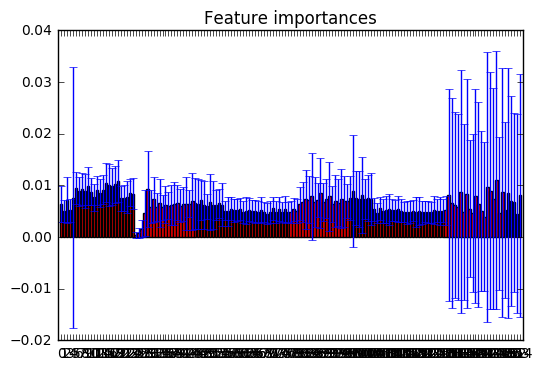

 processing drive LM-41SHL015.drv 

 6 of 10 - Drive: LM-41SHL015.drv
 Engineering features for drive LM-41SHL015.drv 
 Engineering features for drive LM-41SHL015.drv Done! 
 ====== Scores on the train set ==================


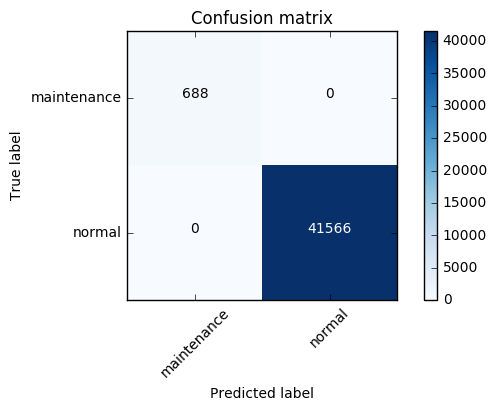

[[  688     0]
 [    0 41566]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       688
     normal       1.00      1.00      1.00     41566

avg / total       1.00      1.00      1.00     42254

 ====== Scores on the test set ==================


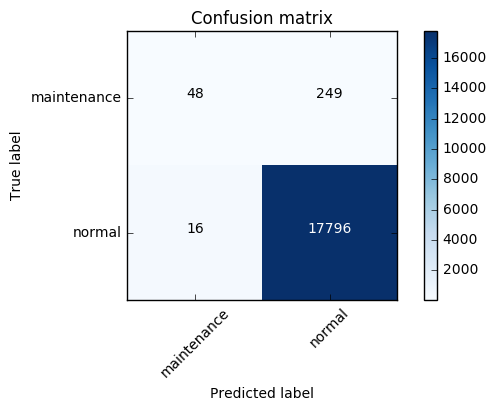

[[   48   249]
 [   16 17796]]
accuracy: 0.985366392402
             precision    recall  f1-score   support

maintenance       0.75      0.16      0.27       297
     normal       0.99      1.00      0.99     17812

avg / total       0.98      0.99      0.98     18109

Feature ranking:
0. LM-41SHL015.drv_Frequentie (0.000002)
1. LM-41SHL015.drv_Koppel (0.012943)
2. LM-41SHL015.drv_Snelheid (0.000016)
3. LM-41SHL015.drv_Stroom (0.013548)
4. LM-41SHL015.drv_Temperatuur (0.002933)
5. LM-41SHL015.drv_Frequentie_EXPANDED_SHIFT_P1 (0.000014)
6. LM-41SHL015.drv_Frequentie_EXPANDED_SHIFT_P2 (0.000001)
7. LM-41SHL015.drv_Frequentie_EXPANDED_SHIFT_P4 (0.000018)
8. LM-41SHL015.drv_Frequentie_EXPANDED_SHIFT_P8 (0.000097)
9. LM-41SHL015.drv_Frequentie_EXPANDED_SHIFT_P16 (0.000210)
10. LM-41SHL015.drv_Koppel_EXPANDED_SHIFT_P1 (0.018398)
11. LM-41SHL015.drv_Koppel_EXPANDED_SHIFT_P2 (0.017423)
12. LM-41SHL015.drv_Koppel_EXPANDED_SHIFT_P4 (0.020640)
13. LM-41SHL015.drv_Koppel_EXPANDED_SHIFT_P8 (0.0251

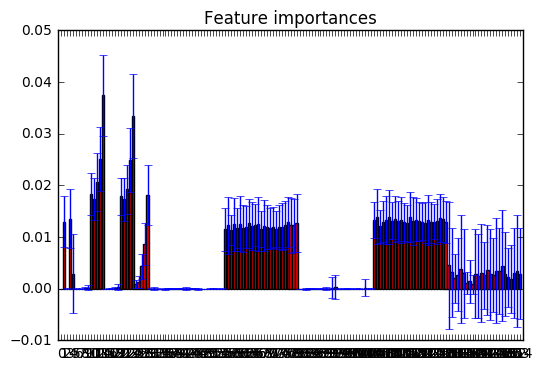

 processing drive LM-55BRL041.drv 

 7 of 10 - Drive: LM-55BRL041.drv
 Engineering features for drive LM-55BRL041.drv 
 Engineering features for drive LM-55BRL041.drv Done! 
 ====== Scores on the train set ==================


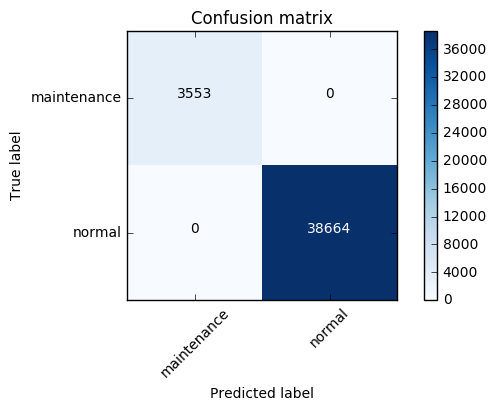

[[ 3553     0]
 [    0 38664]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00      3553
     normal       1.00      1.00      1.00     38664

avg / total       1.00      1.00      1.00     42217

 ====== Scores on the test set ==================


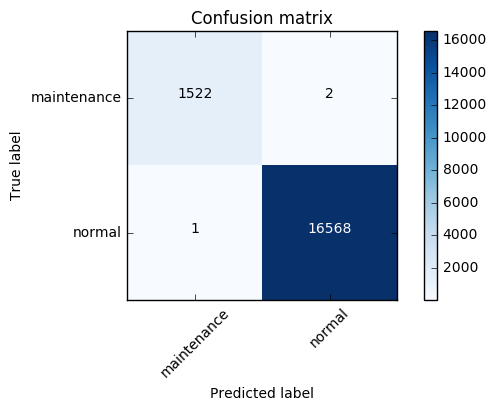

[[ 1522     2]
 [    1 16568]]
accuracy: 0.999834190018
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00      1524
     normal       1.00      1.00      1.00     16569

avg / total       1.00      1.00      1.00     18093

Feature ranking:
0. LM-55BRL041.drv_Frequentie (0.000406)
1. LM-55BRL041.drv_Koppel (0.001555)
2. LM-55BRL041.drv_Snelheid (0.000550)
3. LM-55BRL041.drv_Stroom (0.000301)
4. LM-55BRL041.drv_Temperatuur (0.017083)
5. LM-55BRL041.drv_Frequentie_EXPANDED_SHIFT_P1 (0.000170)
6. LM-55BRL041.drv_Frequentie_EXPANDED_SHIFT_P2 (0.000137)
7. LM-55BRL041.drv_Frequentie_EXPANDED_SHIFT_P4 (0.000138)
8. LM-55BRL041.drv_Frequentie_EXPANDED_SHIFT_P8 (0.000198)
9. LM-55BRL041.drv_Frequentie_EXPANDED_SHIFT_P16 (0.000286)
10. LM-55BRL041.drv_Koppel_EXPANDED_SHIFT_P1 (0.000066)
11. LM-55BRL041.drv_Koppel_EXPANDED_SHIFT_P2 (0.000107)
12. LM-55BRL041.drv_Koppel_EXPANDED_SHIFT_P4 (0.000201)
13. LM-55BRL041.drv_Koppel_EXPANDED_SHIFT_P8 (0.0002

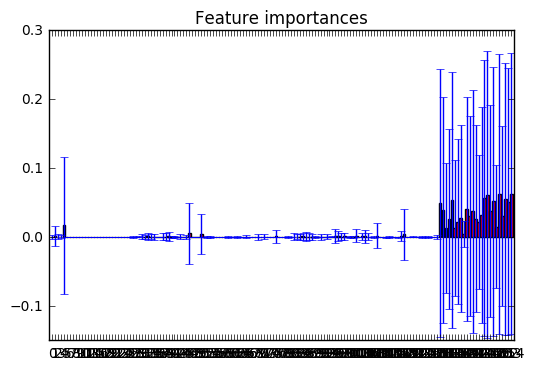

 processing drive LM-34CHP102.drv 

 8 of 10 - Drive: LM-34CHP102.drv
 Engineering features for drive LM-34CHP102.drv 
 Engineering features for drive LM-34CHP102.drv Done! 
 ====== Scores on the train set ==================


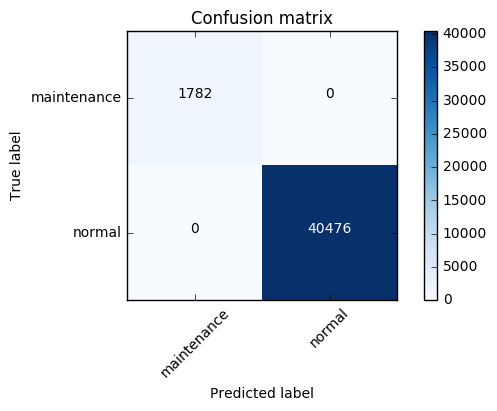

[[ 1782     0]
 [    0 40476]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00      1782
     normal       1.00      1.00      1.00     40476

avg / total       1.00      1.00      1.00     42258

 ====== Scores on the test set ==================


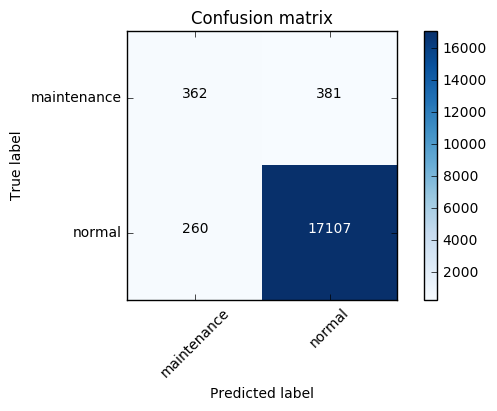

[[  362   381]
 [  260 17107]]
accuracy: 0.964605190502
             precision    recall  f1-score   support

maintenance       0.58      0.49      0.53       743
     normal       0.98      0.99      0.98     17367

avg / total       0.96      0.96      0.96     18110

Feature ranking:
0. LM-34CHP102.drv_Frequentie (0.009047)
1. LM-34CHP102.drv_Koppel (0.000645)
2. LM-34CHP102.drv_Snelheid (0.002533)
3. LM-34CHP102.drv_Stroom (0.004796)
4. LM-34CHP102.drv_Temperatuur (0.004531)
5. LM-34CHP102.drv_Frequentie_EXPANDED_SHIFT_P1 (0.000306)
6. LM-34CHP102.drv_Frequentie_EXPANDED_SHIFT_P2 (0.000444)
7. LM-34CHP102.drv_Frequentie_EXPANDED_SHIFT_P4 (0.000112)
8. LM-34CHP102.drv_Frequentie_EXPANDED_SHIFT_P8 (0.000173)
9. LM-34CHP102.drv_Frequentie_EXPANDED_SHIFT_P16 (0.000278)
10. LM-34CHP102.drv_Koppel_EXPANDED_SHIFT_P1 (0.025923)
11. LM-34CHP102.drv_Koppel_EXPANDED_SHIFT_P2 (0.025097)
12. LM-34CHP102.drv_Koppel_EXPANDED_SHIFT_P4 (0.024525)
13. LM-34CHP102.drv_Koppel_EXPANDED_SHIFT_P8 (0.0250

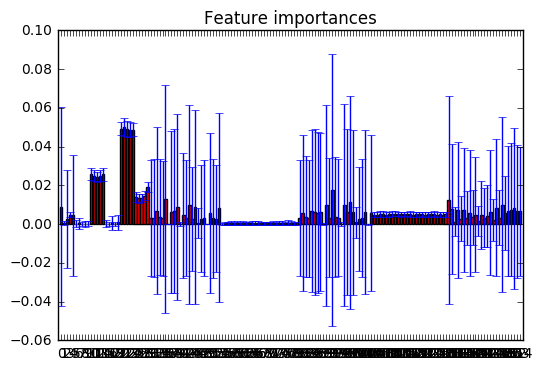

 processing drive LM-41SHL009.1.drv 

 9 of 10 - Drive: LM-41SHL009.1.drv
 Engineering features for drive LM-41SHL009.1.drv 
 Engineering features for drive LM-41SHL009.1.drv Done! 
 ====== Scores on the train set ==================


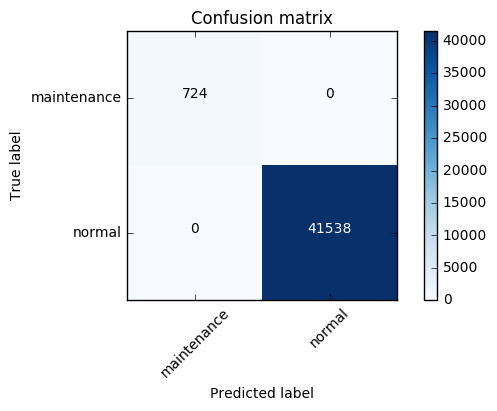

[[  724     0]
 [    0 41538]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       724
     normal       1.00      1.00      1.00     41538

avg / total       1.00      1.00      1.00     42262

 ====== Scores on the test set ==================


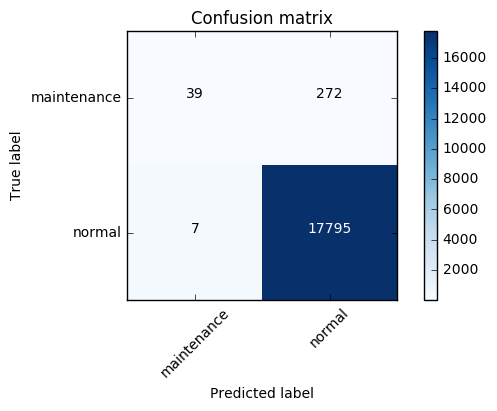

[[   39   272]
 [    7 17795]]
accuracy: 0.984596698504
             precision    recall  f1-score   support

maintenance       0.85      0.13      0.22       311
     normal       0.98      1.00      0.99     17802

avg / total       0.98      0.98      0.98     18113

Feature ranking:
0. LM-41SHL009.1.drv_Frequentie (0.005724)
1. LM-41SHL009.1.drv_Koppel (0.006987)
2. LM-41SHL009.1.drv_Snelheid (0.007061)
3. LM-41SHL009.1.drv_Stroom (0.006541)
4. LM-41SHL009.1.drv_Temperatuur (0.004892)
5. LM-41SHL009.1.drv_Frequentie_EXPANDED_SHIFT_P1 (0.008542)
6. LM-41SHL009.1.drv_Frequentie_EXPANDED_SHIFT_P2 (0.008739)
7. LM-41SHL009.1.drv_Frequentie_EXPANDED_SHIFT_P4 (0.009967)
8. LM-41SHL009.1.drv_Frequentie_EXPANDED_SHIFT_P8 (0.010687)
9. LM-41SHL009.1.drv_Frequentie_EXPANDED_SHIFT_P16 (0.011744)
10. LM-41SHL009.1.drv_Koppel_EXPANDED_SHIFT_P1 (0.009143)
11. LM-41SHL009.1.drv_Koppel_EXPANDED_SHIFT_P2 (0.009289)
12. LM-41SHL009.1.drv_Koppel_EXPANDED_SHIFT_P4 (0.009674)
13. LM-41SHL009.1.drv_Kopp

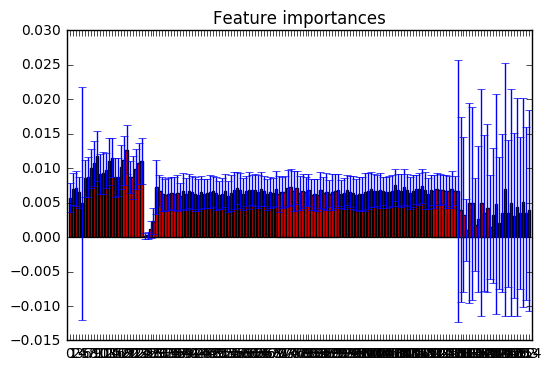

 processing drive LM-34LBL102.1.drv 

 10 of 10 - Drive: LM-34LBL102.1.drv
 Engineering features for drive LM-34LBL102.1.drv 
 Engineering features for drive LM-34LBL102.1.drv Done! 
 ====== Scores on the train set ==================


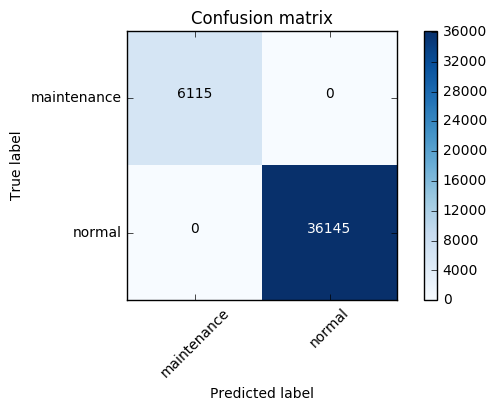

[[ 6115     0]
 [    0 36145]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00      6115
     normal       1.00      1.00      1.00     36145

avg / total       1.00      1.00      1.00     42260

 ====== Scores on the test set ==================


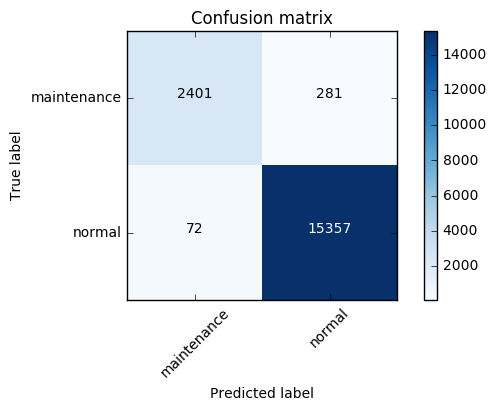

[[ 2401   281]
 [   72 15357]]
accuracy: 0.980509082878
             precision    recall  f1-score   support

maintenance       0.97      0.90      0.93      2682
     normal       0.98      1.00      0.99     15429

avg / total       0.98      0.98      0.98     18111

Feature ranking:
0. LM-34LBL102.1.drv_Frequentie (0.003795)
1. LM-34LBL102.1.drv_Koppel (0.012069)
2. LM-34LBL102.1.drv_Snelheid (0.010200)
3. LM-34LBL102.1.drv_Stroom (0.017253)
4. LM-34LBL102.1.drv_Temperatuur (0.000511)
5. LM-34LBL102.1.drv_Frequentie_EXPANDED_SHIFT_P1 (0.003841)
6. LM-34LBL102.1.drv_Frequentie_EXPANDED_SHIFT_P2 (0.003956)
7. LM-34LBL102.1.drv_Frequentie_EXPANDED_SHIFT_P4 (0.005028)
8. LM-34LBL102.1.drv_Frequentie_EXPANDED_SHIFT_P8 (0.005151)
9. LM-34LBL102.1.drv_Frequentie_EXPANDED_SHIFT_P16 (0.005405)
10. LM-34LBL102.1.drv_Koppel_EXPANDED_SHIFT_P1 (0.001607)
11. LM-34LBL102.1.drv_Koppel_EXPANDED_SHIFT_P2 (0.001993)
12. LM-34LBL102.1.drv_Koppel_EXPANDED_SHIFT_P4 (0.001719)
13. LM-34LBL102.1.drv_Kopp

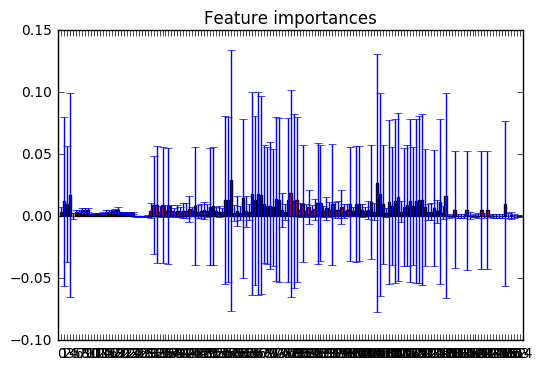

In [140]:
drives = ["LM-41BAL380.drv", "LM-41BAL300.drv","LM-41SHL009.2.drv", "LM-41BFL060.1.drv", 
          "LM-41BFL030.1.drv", "LM-41SHL015.drv", "LM-55BRL041.drv", "LM-34CHP102.drv", "LM-41SHL009.1.drv","LM-34LBL102.1.drv"]     

first_time = True        
for index, drive_name in enumerate(drives):
    seq = str(index+1)+" of "+str(len(drives))
    process_drive_file(drive_name, seq)
    
    train, test, columns, target, name = prepare_build_model_data(drive_name)      
    model, predictions, accu, conf = rf_class_drive(train, test, columns, target, name)
#     if first_time:
#         fitfix = model.fit(train[columns], train[target].values.ravel())
#         drive_model = re.search('LM.+\.drv',columns[1]).group(0)
#         accu_model = accu
#         first_time = False
#     else:
#         pred = fitfix.predict(test[columns])
#         print("Accuracy of present model:", accu)
#         print(re.search('LM.+\.drv',columns[1]).group(0))
#         print(" ================================================= ")
#         print("Accuracy of control model fit:", accuracy_score(pred, test[target]))
#         classification_report(test[target], pred)
#         print(drive_model)
#         print(" =================================================")
#         print("Accuracy of original control model:", accu_model)
#         print("--------------------------------------------------------")


### Key Findings
* The prediction rate in general for all drives are good with accuracy higher than 0,95.
* Not all drives demonstrated a good recall or precision result. 
* The reutilization of one model to another equipment still maintained the accuracy to a reasonable level for some drives. However, a deeper analysis is needed to understand if it is possible to generalize the model to include different drives. 
* When it comes to feature importance, there seems to be two clusters of drivers. One where variables are somehow balanced, and another where we find fewer features with much higher impact. It is important to understand better how accurate is the  information being captured by different drives. 
* It would be necessary to clarify the gap between the time the equipment comes back to a normal state, and the time the notification is closed in SAP. This gap may generate inconsistent feedback to a prediction model. 

LM-41BAL300.drv_Frequentie LM-41BAL300.drv_Koppel  \
2016-09-01 00:00:00                      33.68                     68   
2016-09-01 00:01:00                      33.52                     65   
2016-09-01 00:02:00                      33.47                67.7143   
2016-09-01 00:03:00                    33.5675                68.9524   
2016-09-01 00:04:00                      33.48                68.3333   
2016-09-01 00:05:00                    33.4683                     66   
2016-09-01 00:06:00                      33.51                 67.875   
2016-09-01 00:07:00                      34.07                     71   
2016-09-01 00:08:00                     34.115                70.7059   
2016-09-01 00:09:00                     34.185                  70.05   
2016-09-01 00:10:00                      34.13                69.9375   
2016-09-01 00:11:00                     34.166                69.8333   
2016-09-01 00:12:00                    34.1133                68.6296   
2016-09-01 00:13:00                    33.5067                66.8333   
2016-09-01 00:14:00                    33.8333                     69   
2016-09-01 00:15:00                     33.505                69.8125   
2016-09-01 00:16:00                    33.8525                   69.4   
2016-09-01 00:17:00                    33.8986                71.6667   
2016-09-01 00:18:00                      33.86                69.6667   
2016-09-01 00:19:00                    33.8267                   70.4   
2016-09-01 00:20:00                      33.84                  68.75   
2016-09-01 00:21:00                    33.4975                65.7273   
2016-09-01 00:22:00                     33.875                     69   
2016-09-01 00:23:00                    33.9055                   68.5   
2016-09-01 00:24:00                      33.71                     69   
2016-09-01 00:25:00                      33.78                   67.6   
2016-09-01 00:26:00                      33.64                67.6667   
2016-09-01 00:27:00                    33.4171                68.8235   
2016-09-01 00:28:00                    33.8425                     70   
2016-09-01 00:29:00                     33.935                69.8667   
...                                        ...                    ...   
2016-10-12 23:31:00                    33.7033                69.9286   
2016-10-12 23:32:00                      33.67                68.6538   
2016-10-12 23:33:00                    33.7969                   69.6   
2016-10-12 23:34:00                    33.7088                 68.775   
2016-10-12 23:35:00                       33.7                     70   
2016-10-12 23:36:00                    33.9933                   70.5   
2016-10-12 23:37:00                    34.5067                   72.5   
2016-10-12 23:38:00                    34.7367                     72   
2016-10-12 23:39:00                     34.445                70.7083   
2016-10-12 23:40:00                    34.1586                     71   
2016-10-12 23:41:00                      34.31                     72   
2016-10-12 23:42:00                    34.3333                71.4118   
2016-10-12 23:43:00                      33.86                     69   
2016-10-12 23:44:00                      33.95                     70   
2016-10-12 23:45:00                      33.79                     69   
2016-10-12 23:46:00                      33.73                     69   
2016-10-12 23:47:00                    34.1717                69.7647   
2016-10-12 23:48:00                      33.94                68.1429   
2016-10-12 23:49:00                      34.15                71.5417   
2016-10-12 23:50:00                      34.14                69.4857   
2016-10-12 23:51:00                      33.86                68.2667   
2016-10-12 23:52:00                    34.2233                70.3125   
2016-10-12 23:53:00                       33.8                71.8889   
2016-

In [ ]:
train = pd.read_excel("data/building_model/LM-34LBL102.1.drv_train.xlsx")

In [ ]:
train.columns